Import 

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

Franke Function

In [72]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

Create design matrix for for two dimensions

In [73]:
def create_X(x, y, n):
    #n is the order of the polynomial, in this project it will be 5
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta, 
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

R2 score function

In [74]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Mean Squared Error (MSE)

In [75]:
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

Make design matrix

In [76]:
n = 100 #size of x and y
N = 5 #polynomial degree

x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)

z = FrankeFunction(x,y)

X = create_X(x, y, N)

DesignMatrix = pd.DataFrame(X)
display(DesignMatrix)

[0.38724565 0.87703135 0.40851486 0.46793333 0.35762429 0.50456624
 1.10197087 0.29379202 0.13292754 1.18768534 0.14464594 0.42982963
 0.88420368 0.60617018 0.54253871 0.06387511 0.05178954 0.41601231
 0.36057234 0.10189707 0.06365976 0.17023722 0.39650248 0.1212785
 0.10630449 1.10885899 0.26324672 0.12769534 0.92975486 0.21807821
 0.9370713  0.10533203 1.03184389 0.3470535  0.59126875 0.50542747
 0.59854712 0.56427584 0.04185125 0.62460688 0.27395036 0.68889148
 0.28635709 0.25967929 0.24888156 0.3253119  0.15312787 0.10675689
 0.60101725 0.39633991 1.10973017 0.14038827 0.16741638 0.29437582
 0.91624271 0.28778633 0.40580684 0.10098753 0.73470272 1.03620746
 0.1342656  0.573267   0.31800324 0.09590853 0.79087198 0.32035473
 0.76773848 0.14375194 0.96995999 0.9919592  0.10414596 0.95455202
 0.80894987 0.5611366  0.49996243 0.5068064  1.01350499 0.30350825
 0.50221648 0.37875199 0.36930862 0.064283   0.273201   0.12995313
 0.09139801 0.12989715 0.29802263 0.41988485 0.37462289 0.12913

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.584645,0.087566,0.341810,0.051195,0.007668,1.998376e-01,0.029931,0.004483,0.000671,...,1.749903e-02,0.002621,0.000393,5.879588e-05,6.830649e-02,1.023072e-02,1.532324e-03,2.295065e-04,3.437473e-05,5.148534e-06
1,1.0,0.203034,0.374677,0.041223,0.076072,0.140383,8.369585e-03,0.015445,0.028502,0.052598,...,3.135889e-03,0.005787,0.010679,1.970729e-02,3.450165e-04,6.366909e-04,1.174945e-03,2.168234e-03,4.001243e-03,7.383865e-03
2,1.0,0.727486,0.136750,0.529236,0.099484,0.018701,3.850117e-01,0.072373,0.013604,0.002557,...,5.265049e-02,0.009897,0.001860,3.497148e-04,2.037620e-01,3.830250e-02,7.199974e-03,1.353427e-03,2.544126e-04,4.782362e-05
3,1.0,0.531355,0.144344,0.282339,0.076698,0.020835,1.500221e-01,0.040754,0.011071,0.003007,...,2.165481e-02,0.005883,0.001598,4.341067e-04,4.235703e-02,1.150640e-02,3.125745e-03,8.491170e-04,2.306649e-04,6.266075e-05
4,1.0,0.640015,0.082173,0.409619,0.052592,0.006752,2.621621e-01,0.033660,0.004322,0.000555,...,2.154273e-02,0.002766,0.000355,4.559566e-05,1.073866e-01,1.378767e-02,1.770238e-03,2.272859e-04,2.918189e-05,3.746747e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.396104,0.067120,0.156898,0.026586,0.004505,6.214796e-02,0.010531,0.001784,0.000302,...,4.171353e-03,0.000707,0.000120,2.029553e-05,9.750903e-03,1.652289e-03,2.799800e-04,4.744257e-05,8.039135e-06,1.362230e-06
96,1.0,0.329046,0.152058,0.108272,0.050034,0.023122,3.562638e-02,0.016464,0.007608,0.003516,...,5.417276e-03,0.002503,0.001157,5.346101e-04,3.857324e-03,1.782535e-03,8.237402e-04,3.806645e-04,1.759116e-04,8.129175e-05
97,1.0,0.917229,0.027876,0.841309,0.025569,0.000777,7.716726e-01,0.023453,0.000713,0.000022,...,2.151153e-02,0.000654,0.000020,6.038831e-07,6.492149e-01,1.973099e-02,5.996661e-04,1.822510e-05,5.538990e-07,1.683415e-08
98,1.0,0.003439,0.336726,0.000012,0.001158,0.113384,4.068215e-08,0.000004,0.000390,0.038179,...,1.369873e-08,0.000001,0.000131,1.285600e-02,4.812158e-13,4.711382e-11,4.612717e-09,4.516118e-07,4.421542e-05,4.328947e-03


Perform the Ordinary Least Square (OLS) method

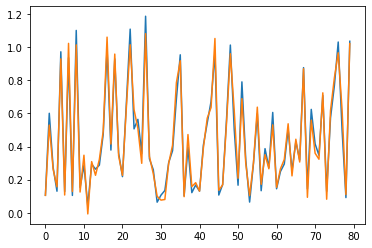

Training R2
0.9740831878651247
Training MSE
0.0024849599849563206
Test R2
0.9731464838923019
Test MSE
0.0026385077421088522
MSE before scaling: 0.00
R2 score before scaling 0.97
Feature min values before scaling:
 [1.00000000e+00 3.43928351e-03 1.48313113e-02 1.18286710e-05
 3.78848408e-04 2.19967795e-04 4.06821532e-08 3.98301921e-06
 1.33360407e-05 3.26241085e-06 1.39917459e-10 1.36987323e-08
 1.43526116e-07 4.69448935e-07 4.83858310e-08 4.81215808e-13
 4.71138239e-11 1.54466731e-09 5.05233780e-09 1.65253172e-08
 7.17625324e-10]
Feature max values before scaling:
 [1.         0.99176846 0.97693214 0.98360467 0.89212523 0.95439641
 0.97550809 0.87588209 0.81064708 0.93238053 0.96747815 0.85993468
 0.79588743 0.76535287 0.91087251 0.95951431 0.84427764 0.78139651
 0.72319872 0.74294454 0.88986063]
Feature min values after scaling:
 [ 0.         -1.58350863 -1.43985689 -1.04340172 -1.00050167 -0.97134969
 -0.85222558 -0.76613483 -0.73153156 -0.7831913  -0.75068606 -0.65512493
 -0.5921812

In [96]:
# splitting the data in training and testing
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

# matrix inversion to find beta
beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)

z_tilde = X_train @ beta

print("Training R2")
print(R2(z_train, z_tilde))
print("Training MSE")
print(MSE(z_train, z_tilde))
z_predict = X_test @ beta


# The mean squared error and R2 score
print("MSE before scaling: {:.2f}".format(MSE(z_test,z_predict)))
print("R2 score before scaling {:.2f}".format(R2(z_test,z_predict)))

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature min values before scaling:\n {}".format(X_train.min(axis=0)))
print("Feature max values before scaling:\n {}".format(X_train.max(axis=0)))

print("Feature min values after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("Feature max values after scaling:\n {}".format(X_train_scaled.max(axis=0)))

clf = skl.LinearRegression().fit(X_train_scaled, y_train)


print("MSE after  scaling: {:.2f}".format(mean_squared_error(clf.predict(X_test_scaled), y_test)))
print("R2 score for  scaled data: {:.2f}".format(clf.score(X_test_scaled,y_test)))

